# Experimenting to optimize for h

Note, section _Optuna_, _Two hidden layers_ is self-contained, and the code can be run from there.

In [1]:
# Import the necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define a new class that inherits from nn.Module
class VariableNetwork(nn.Module):
    # Define the constructor that takes the model as an argument
    def __init__(self, model):
        # Call the parent constructor
        super().__init__()
        # Assign the model to an attribute
        self.model = model
    
    # Override the forward function
    def forward(self, x):
        # Loop over the layers in the ModuleList
        for layer in self.model:
            # Apply the layer to the input
            x = layer(x)
        # Return the final output
        return x


# Define the functions to be approximated
def f(x1, x2, x3):
    return x1 + x2 + x3

def g(x1, x2, x3):
    return x1**2 + x2**3 + 0.5 * x3

def h(x1, x2, x3):
    return x3 * x1**(x2)


In [2]:
# Define the range and step size for the input variables
x1_range = (0, 10)
x2_range = (0, 10)
x3_range = (0, 10)
dx = 0.5

# Generate the input data by sampling uniformly from the ranges
x1 = np.arange(*x1_range, dx)
x2 = np.arange(*x2_range, dx)
x3 = np.arange(*x3_range, dx)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X = np.stack([X1.flatten(), X2.flatten(), X3.flatten()], axis=1)

# Compute the output data by applying the functions
Y_f = f(X[:, 0], X[:, 1], X[:, 2])
Y_g = g(X[:, 0], X[:, 1], X[:, 2])
Y_h = h(X[:, 0], X[:, 1], X[:, 2])

# Convert the input and output data to torch tensors
X = torch.from_numpy(X).float()
Y_f = torch.from_numpy(Y_f).float().unsqueeze(1)
Y_g = torch.from_numpy(Y_g).float().unsqueeze(1)
Y_h = torch.from_numpy(Y_h).float().unsqueeze(1)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = torch.utils.data.random_split(X, [train_size, test_size])
Y_f_train, Y_f_test = torch.utils.data.random_split(Y_f, [train_size, test_size])
Y_g_train, Y_g_test = torch.utils.data.random_split(Y_g, [train_size, test_size])
Y_h_train, Y_h_test = torch.utils.data.random_split(Y_h, [train_size, test_size])


In [3]:
# Let us have a variable number of hidden layers.
# Define a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activations, output_activation=None):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes and activations
    for hidden_size, activation in zip(hidden_sizes, activations):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Use a batch normalization layer between linear and activation layers to improve training stability
        #model.append(nn.BatchNorm1d(hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # If an output activation function is specified, add it to the model
    if output_activation:
        model.append(output_activation())
    # Return the model
    return model



In [4]:
# Define a function to train a neural network with given hyperparameters and data
def train_network(model, optimizer, loss_fn, batch_size, epochs,
                  X_train, Y_train, X_test=None, Y_test=None):
    # Create a data loader for the training data
    train_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, Y_train),
        batch_size=batch_size,
        shuffle=True
    )
    # Initialize a list to store the training losses
    train_losses = []
    # Initialize a list to store the test losses if test data is given
    if X_test is not None and Y_test is not None:
        test_losses = []
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Initialize a variable to store the running loss for this epoch
        running_loss = 0.0
        # Loop over the batches of training data
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute the outputs from the inputs
            outputs = model(inputs)
            # Compute the loss from the outputs and targets
            loss = loss_fn(outputs, targets)
            # Backward pass: compute the gradients from the loss
            loss.backward()
            # Update the parameters using the optimizer
            optimizer.step()
            # Accumulate the running loss
            running_loss += loss.item()
        # Compute and append the average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        # Print the progress
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
        # If test data is given, compute and append the test loss for this epoch
        if X_test is not None and Y_test is not None:
            # Compute the outputs from the test inputs
            outputs = model(X_test)
            # Compute the loss from the outputs and test targets
            loss = loss_fn(outputs, Y_test)
            # Append the test loss
            test_loss = loss.item()
            test_losses.append(test_loss)
            # Print the progress
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
    # Return the train and test losses if test data is given, otherwise return only train losses
    if X_test is not None and Y_test is not None:
        return train_losses, test_losses
    else:
        return train_losses

In [5]:
# Define a function to plot the losses during training
def plot_losses(train_losses, test_losses=None, function_name=None, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the train losses
    ax.plot(train_losses, label="Train Loss")
    # If test losses are given, plot them as well
    if test_losses is not None:
        ax.plot(test_losses, label="Test Loss")
    # Set the title, labels, and legend
    ax.set_title(f"Losses during Training ({hyperparameters})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"losses_{function_name}_{hyperparameters}.png")
    plt.show()

In [6]:
# Define a function to plot the predictions versus the true values
def plot_predictions(model, X, Y_true, function_name, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Compute the predictions from the inputs
    Y_pred = model(X).detach().numpy()
    # Plot the predictions and the true values as scatter plots
    ax.scatter(Y_true, Y_pred, label="Predictions", s=2, alpha=0.3)
    ax.scatter(Y_true, Y_true, label="True Values", s=2, alpha=0.3)
    # Set the title, labels, and legend
    ax.set_title(f"Predictions versus True Values ({hyperparameters})")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"predictions_{function_name}_{hyperparameters}.png")
    plt.show()

In [7]:
# Define a list of functions to be approximated
functions = [f, g, h]
# Define a list of function names for printing and plotting purposes
function_names = ["f", "g", "h"]
# Define a list of output tensors for each function
outputs = [Y_f, Y_g, Y_h]
# Define a list of output tensors for each function for train and test sets
outputs_train = [Y_f_train, Y_g_train, Y_h_train]
outputs_test = [Y_f_test, Y_g_test, Y_h_test]


In [8]:
%%script echo skipping

# Loop over each function to be approximated
for i in range(len(functions)):
    # Print the function name
    print(f"Approximating function {function_names[i]}")
    # Create a neural network with given hyperparameters
    input_size = 3 # The number of input variables (x1, x2, x3)
    output_size = 1 # The number of output variables (y)
    # Create a network with 3 hidden layers and ReLU activations, and an optional output activation
    hidden_sizes = [64, 128, 256, 512]
    activations = [nn.ELU, nn.ELU, nn.ELU, nn.ELU]


    output_activation = None
    model = create_network(input_size, output_size,
                        hidden_sizes, activations, output_activation=output_activation)

    # Create an instance of VariableNetwork by passing the model
    network = VariableNetwork(model)

    # Create an optimizer with given hyperparameters
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    # Create a loss function with given hyperparameters
    loss_fn = nn.MSELoss()
    # Train the network with given hyperparameters and data
    batch_size = 64 # The number of samples in each batch
    epochs = 100 # The number of times to loop over the whole dataset
    # Create a string representation of the hyperparameters
    hyperparameters_str = f"hidden_sizes_{hidden_sizes}_activations_{[act.__name__ for act in activations]}_optimizer_{optimizer.__class__.__name__}_lr_{optimizer.param_groups[0]['lr']}_batch_size_{batch_size}_epochs_{epochs}"
    if output_activation:
        hyperparameters_str += f"_output_activation_{output_activation.__name__}"

    if output_activation:
        hyperparameters_str += f"_output_activation_{output_activation.__name__}"

    train_losses, test_losses = train_network(network, optimizer, loss_fn,
                                            batch_size, epochs,
                                            X_train.dataset, outputs_train[i].dataset,
                                            X_test.dataset, outputs_test[i].dataset)
    plot_losses(train_losses, test_losses, function_names[i], hyperparameters=hyperparameters_str)
    plot_predictions(network, X, outputs[i], function_names[i], hyperparameters=hyperparameters_str)

    # Save the network with hyperparameters in the file name
    torch.save(network, f"network_{function_names[i]}_{hyperparameters_str}.pt")


skipping


# Convert notebook to python script

Running the cell converts this whole notebook to a python script.

In [42]:
!jupyter nbconvert script.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script




[NbConvertApp] Converting notebook script.ipynb to script
[NbConvertApp] Writing 25100 bytes to script.py


# Ray Tune

I will now implement Ray Tune to find good parameters for our network.
I had asked C too to implement more different activation functions, upon which he modified the `create_network` function too.

In [10]:
import multiprocessing

num_cpus = multiprocessing.cpu_count()
print(f"Number of CPUs: {num_cpus}")

input_size = 3  # The number of input variables (x1, x2, x3)
output_size = 1  # The number of output variables (y)


Number of CPUs: 4


In [11]:
%%script echo skipping
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.skopt import SkOptSearch

# Create a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activation_classes, output_activation_class=None):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes
    for hidden_size, activation_class in zip(hidden_sizes, activation_classes):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation_class())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # If an output activation function is specified, add it to the model
    if output_activation_class:
        model.append(output_activation_class())
    # Return the model
    return model

def tune_network(config):
    activation_classes = [getattr(nn, act_class_name) for act_class_name in config["activation_classes"]]
    hidden_sizes = config["hidden_sizes"]
    output_activation_class = getattr(nn, config["output_activation_class"]) if config["output_activation_class"] else None

    model = create_network(input_size, output_size, hidden_sizes, activation_classes, output_activation_class=output_activation_class)
    network = VariableNetwork(model)
    optimizer = optim.Adam(network.parameters(), lr=config["lr"])
    loss_fn = nn.MSELoss()

    train_losses, test_losses = train_network(network, optimizer, loss_fn,
                                              config["batch_size"], config["epochs"],
                                              X_train.dataset, Y_f_train.dataset,
                                              X_test.dataset, Y_f_test.dataset)

    tune.report(test_loss=test_losses[-1])


skipping


In [12]:
%%script echo skipping

from skopt.space import Real, Integer, Categorical

# Define the search space for SkOpt
# This tries just one hidden layer.
search_space = {
    "hidden_sizes": Integer(32, 1024),
    "activation_classes": Categorical(["ReLU", "ELU", "LeakyReLU", "Tanh", "Sigmoid"]),
    "output_activation_class": Categorical([None, "ReLU", "ELU", "LeakyReLU", "Tanh", "Sigmoid"]),
    "lr": Real(1e-4, 1e-2, "log-uniform"),
    "batch_size": Integer(32, 256),
    "epochs": Integer(10, 50),
}

# Initialize SkOpt search algorithm
skopt_search = SkOptSearch(space=search_space, metric="test_loss", mode="min")


skipping


In [13]:
%%script echo skipping

# Set up the scheduler, searcher, and resources
asha_scheduler = ASHAScheduler(
    metric="test_loss",
    mode="min",
    max_t=200,
    grace_period=50,
    reduction_factor=2
)

resources_per_trial = {"cpu": num_cpus, "gpu": 0}

for i in range(len(functions)):
    # Print the function name
    print(f"Approximating function {function_names[i]}")

    # Start the tuning process
    analysis = tune.run(
        tune_network,
        search_alg=skopt_search,
        scheduler=asha_scheduler,
        num_samples=50,
        resources_per_trial=resources_per_trial,
        config=search_space,
        name=f"tune_network_{function_names[i]}"
    )

    # Get the best set of hyperparameters
    best_trial = analysis.get_best_trial("test_loss", "min", "last")
    best_config = best_trial.config
    print(f"Best configuration: {best_config}")

    # Train the network with the best hyperparameters
    best_activation_classes = [getattr(nn, act_class_name) for act_class_name in best_config["activation_classes"]]
    best_hidden_sizes = best_config["hidden_sizes"]
    best_output_activation_class = getattr(nn, best_config["output_activation_class"]) if best_config["output_activation_class"] else None
    best_model = create_network(input_size, output_size, best_hidden_sizes, best_activation_classes, output_activation_class=best_output_activation_class)
    best_network = VariableNetwork(best_model)
    best_optimizer = optim.Adam(best_network.parameters(), lr=best_config["lr"])
    best_loss_fn = nn.MSELoss()

    best_train_losses, best_test_losses = train_network(best_network, best_optimizer, best_loss_fn,
                                                         best_config["batch_size"], best_config["epochs"],
                                                         X_train.dataset, outputs_train[i].dataset,
                                                         X_test.dataset, outputs_test[i].dataset)

    # Print the test loss for the best model
    print(f"Test loss for the best model: {best_test_losses[-1]}")


skipping


# Optuna

Let's see if switching to Optuna will avoid having to downgrade numpy.

In [14]:
import optuna

In [15]:
# Create a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activation_classes, output_activation_class=None):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes
    for hidden_size, activation_class in zip(hidden_sizes, activation_classes):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation_class())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # If an output activation function is specified, add it to the model
    if output_activation_class:
        model.append(output_activation_class())
    # Return the model
    return model

In [16]:
# Modify the function to accept a trial object from Optuna
def tune_network(trial):
    activation_classes = [getattr(nn, trial.suggest_categorical("activation_class", ["ReLU", "ELU", "LeakyReLU", "Tanh", "Sigmoid"])) for _ in range(4)]
    hidden_sizes = [trial.suggest_int("hidden_sizes", 32, 1024) for _ in range(4)]
    output_activation_class_name = trial.suggest_categorical("output_activation_class", [None, "ReLU", "ELU", "LeakyReLU", "Tanh", "Sigmoid"])
    output_activation_class = getattr(nn, output_activation_class_name) if output_activation_class_name else None
    model = create_network(input_size, output_size, hidden_sizes, activation_classes, output_activation_class=output_activation_class)
    network = VariableNetwork(model)
    optimizer = optim.Adam(network.parameters(), lr=trial.suggest_loguniform("lr", 1e-4, 1e-2))
    loss_fn = nn.MSELoss()
    train_losses, test_losses = train_network(network, optimizer, loss_fn,
                                              trial.suggest_int("batch_size", 32, 256), trial.suggest_int("epochs", 10, 50),
                                              X_train.dataset, Y_h_train.dataset, # NOTE: Optimizing FOR h.
                                              X_test.dataset, Y_h_test.dataset) # NOTE: Optimizing FOR h.
    return test_losses[-1]


Code below optimizes for each function respectively, but I'm currently interested in optimizing for _h_.

In [17]:
%%script echo skipping
for i in range(len(functions)):
    # Print the function name
    print(f"Approximating function {function_names[i]}")

    study = optuna.create_study(direction="minimize")
    study.optimize(tune_network, n_trials=50)
    
    # Get the best set of hyperparameters
    best_trial = study.best_trial
    best_config = best_trial.params
    print(f"Best configuration: {best_config}")

    # Train the network with the best hyperparameters
    best_activation_classes = [getattr(nn, act_class_name) for act_class_name in best_config["activation_classes"]]
    best_hidden_sizes = best_config["hidden_sizes"]
    best_output_activation_class = getattr(nn, best_config["output_activation_class"]) if best_config["output_activation_class"] else None
    best_model = create_network(input_size, output_size, best_hidden_sizes, best_activation_classes, output_activation_class=best_output_activation_class)
    best_network = VariableNetwork(best_model)
    best_optimizer = optim.Adam(best_network.parameters(), lr=best_config["lr"])
    best_loss_fn = nn.MSELoss()

    best_train_losses, best_test_losses = train_network(best_network, best_optimizer, best_loss_fn,
                                                         best_config["batch_size"], best_config["epochs"],
                                                         X_train.dataset, outputs_train[i].dataset,
                                                         X_test.dataset, outputs_test[i].dataset)

    # Print the test loss for the best model
    print(f"Test loss for the best model: {best_test_losses[-1]}")

skipping


So we instead go ahead and just optimize for `h`. 

In [18]:
# Print the function name
i = 2 # NOTE: function h
print(f"Approximating function {function_names[i]}")

study = optuna.create_study(direction="minimize")
study.optimize(tune_network, n_trials=50)


[I 2023-05-02 14:43:28,931] A new study created in memory with name: no-name-66374228-2900-4fa5-93dc-6a1cf40faeb6


Approximating function h


/tmp/ipykernel_1561/4078058256.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  optimizer = optim.Adam(network.parameters(), lr=trial.suggest_loguniform("lr", 1e-4, 1e-2))


Epoch 1, Train Loss: 503692336922516032.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 496831807506319232.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 511398556689374720.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 494898688486739712.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 495184535661206080.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 496304206365389056.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 495155251610972416.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 497787152145934720.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 498405491805596992.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 495098599223822208.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train Loss: 499026697408510080.0000
Epoch 11, Test Loss: 500558647139500032.0000
Epoch 12, Train L

[I 2023-05-02 14:43:42,345] Trial 0 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'Sigmoid', 'hidden_sizes': 626, 'output_activation_class': 'Sigmoid', 'lr': 0.0001975682723298191, 'batch_size': 238, 'epochs': 22}. Best is trial 0 with value: 5.005586471395e+17.


Epoch 22, Train Loss: 494980402355449152.0000
Epoch 22, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 499384512234502912.0000
Epoch 1, Test Loss: 500558440981069824.0000
Epoch 2, Train Loss: 499372784673151808.0000
Epoch 2, Test Loss: 500558337901854720.0000
Epoch 3, Train Loss: 500533239517032192.0000
Epoch 3, Test Loss: 500558269182377984.0000
Epoch 4, Train Loss: 499384760563799168.0000
Epoch 4, Test Loss: 500558097383686144.0000
Epoch 5, Train Loss: 499415787626682880.0000
Epoch 5, Test Loss: 500557925584994304.0000
Epoch 6, Train Loss: 499371901997787392.0000
Epoch 6, Test Loss: 500557822505779200.0000
Epoch 7, Train Loss: 499550641598949696.0000
Epoch 7, Test Loss: 500557719426564096.0000
Epoch 8, Train Loss: 499371716029158144.0000
Epoch 8, Test Loss: 500557581987610624.0000
Epoch 9, Train Loss: 499433264887620800.0000
Epoch 9, Test Loss: 500557444548657152.0000
Epoch 10, Train Loss: 499373177756393088.0000
Epoch 10, Test Loss: 500557307109703680.0000
Epoch 11, Train L

[I 2023-05-02 14:45:49,281] Trial 1 finished with value: 5.0055593272016896e+17 and parameters: {'activation_class': 'Tanh', 'hidden_sizes': 924, 'output_activation_class': 'LeakyReLU', 'lr': 0.006368123999707853, 'batch_size': 33, 'epochs': 21}. Best is trial 1 with value: 5.0055593272016896e+17.


Epoch 21, Test Loss: 500555932720168960.0000
Epoch 1, Train Loss: 497396684605382400.0000
Epoch 1, Test Loss: 500539886722351104.0000
Epoch 2, Train Loss: 497230366324588224.0000
Epoch 2, Test Loss: 499999511117037568.0000
Epoch 3, Train Loss: 495449135789548480.0000
Epoch 3, Test Loss: 496527974951026688.0000
Epoch 4, Train Loss: 489602706494772032.0000
Epoch 4, Test Loss: 488785110989012992.0000
Epoch 5, Train Loss: 482820776368948352.0000
Epoch 5, Test Loss: 483235326047813632.0000
Epoch 6, Train Loss: 479132663460597056.0000
Epoch 6, Test Loss: 481181816284250112.0000
Epoch 7, Train Loss: 477876167451766464.0000
Epoch 7, Test Loss: 480212459345412096.0000
Epoch 8, Train Loss: 485828534151267840.0000
Epoch 8, Test Loss: 479357589054816256.0000
Epoch 9, Train Loss: 476143232419959424.0000
Epoch 9, Test Loss: 478476639722799104.0000
Epoch 10, Train Loss: 475389548669716992.0000
Epoch 10, Test Loss: 477634860492521472.0000
Epoch 11, Train Loss: 474467233998474880.0000
Epoch 11, Test Lo

[I 2023-05-02 14:46:10,749] Trial 2 finished with value: 4.7295015068421325e+17 and parameters: {'activation_class': 'LeakyReLU', 'hidden_sizes': 783, 'output_activation_class': 'ELU', 'lr': 0.00024463158389640533, 'batch_size': 83, 'epochs': 16}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 16, Train Loss: 478037900754914304.0000
Epoch 16, Test Loss: 472950150684213248.0000
Epoch 1, Train Loss: 489198128913361600.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 488946141308161088.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 491318655588998784.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 488946121970588992.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 489010118452027008.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 489029719033805312.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 488946123205307520.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 488946226050617152.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 488946125682681280.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 488946137838969152.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:46:23,758] Trial 3 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 876, 'output_activation_class': 'Sigmoid', 'lr': 0.007456916632292656, 'batch_size': 195, 'epochs': 11}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 11, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 497340527415990080.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 497328026694848384.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 497330577778798720.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 497325981962282112.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 505702386430759296.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 497326278074783040.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 507586957841689728.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 497342101077781632.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 497325981249698944.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 498419946162622336.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train Loss: 499493671177869632.0000
Epoch 11, Test Lo

[I 2023-05-02 14:46:29,735] Trial 4 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 152, 'output_activation_class': 'Sigmoid', 'lr': 0.0003140874697449661, 'batch_size': 61, 'epochs': 19}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 19, Train Loss: 497328855185387648.0000
Epoch 19, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 498006317309045376.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 498006305307610368.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 498006319257983936.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 498006318700915840.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 498006308215297344.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 498008781973638336.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 499686398980722816.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 498006309270965056.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 498006316860425856.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 498006338107393344.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:47:03,464] Trial 5 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'Tanh', 'hidden_sizes': 524, 'output_activation_class': 'Sigmoid', 'lr': 0.0003674730556424627, 'batch_size': 43, 'epochs': 38}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 38, Train Loss: 498006316348437696.0000
Epoch 38, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 495357355862996608.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 495437568332652352.0000
Epoch 2, Test Loss: 500558578420023296.0000
Epoch 3, Train Loss: 495357323012736960.0000
Epoch 3, Test Loss: 500558509700546560.0000
Epoch 4, Train Loss: 495357299940307968.0000
Epoch 4, Test Loss: 500558509700546560.0000
Epoch 5, Train Loss: 495357265209295872.0000
Epoch 5, Test Loss: 500558509700546560.0000
Epoch 6, Train Loss: 495357250969825920.0000
Epoch 6, Test Loss: 500558440981069824.0000
Epoch 7, Train Loss: 495357216977007872.0000
Epoch 7, Test Loss: 500558440981069824.0000
Epoch 8, Train Loss: 495357224504878976.0000
Epoch 8, Test Loss: 500558440981069824.0000
Epoch 9, Train Loss: 495357191824305408.0000
Epoch 9, Test Loss: 500558406621331456.0000
Epoch 10, Train Loss: 495357174211577920.0000
Epoch 10, Test Loss: 500558406621331456.0000
Epoch 11, Train L

[I 2023-05-02 14:47:25,592] Trial 6 finished with value: 5.005579255849943e+17 and parameters: {'activation_class': 'Sigmoid', 'hidden_sizes': 517, 'output_activation_class': None, 'lr': 0.005027124445381254, 'batch_size': 86, 'epochs': 32}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 32, Train Loss: 495356745558762432.0000
Epoch 32, Test Loss: 500557925584994304.0000
Epoch 1, Train Loss: 500558602748035072.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 500558601614524416.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 500558612774309056.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 500558588041546944.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 500558611281556288.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 500558614667198464.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 500558610529937024.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 500558612241265472.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 500558601673244672.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 500558591973156480.0000


[I 2023-05-02 14:47:51,440] Trial 7 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ReLU', 'hidden_sizes': 982, 'output_activation_class': 'Tanh', 'lr': 0.006780189105988336, 'batch_size': 100, 'epochs': 10}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 10, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 499353927632473984.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 499309336251795200.0000
Epoch 2, Test Loss: 500558372261593088.0000
Epoch 3, Train Loss: 499293586055339840.0000
Epoch 3, Test Loss: 500557204030488576.0000
Epoch 4, Train Loss: 500686583775285120.0000
Epoch 4, Test Loss: 500553287020314624.0000
Epoch 5, Train Loss: 499203224920370432.0000
Epoch 5, Test Loss: 500543185257234432.0000
Epoch 6, Train Loss: 502145570693178432.0000
Epoch 6, Test Loss: 500522466334998528.0000
Epoch 7, Train Loss: 505315901600772224.0000
Epoch 7, Test Loss: 500480513094451200.0000
Epoch 8, Train Loss: 499642051204048832.0000
Epoch 8, Test Loss: 500404715511611392.0000
Epoch 9, Train Loss: 499083816616867648.0000
Epoch 9, Test Loss: 500286518011625472.0000
Epoch 10, Train Loss: 500101171483891328.0000
Epoch 10, Test Loss: 500099841553072128.0000
Epoch 11, Train Loss: 498909598073707008.0000
Epoch 11, Test Lo

[I 2023-05-02 14:48:09,801] Trial 8 finished with value: 4.787612757954396e+17 and parameters: {'activation_class': 'ReLU', 'hidden_sizes': 500, 'output_activation_class': None, 'lr': 0.0001464320277635724, 'batch_size': 217, 'epochs': 35}. Best is trial 2 with value: 4.7295015068421325e+17.


Epoch 35, Train Loss: 479501554036974208.0000
Epoch 35, Test Loss: 478761275795439616.0000
Epoch 1, Train Loss: 491668296999895040.0000
Epoch 1, Test Loss: 500479241784131584.0000
Epoch 2, Train Loss: 489833892070380864.0000
Epoch 2, Test Loss: 497237022511988736.0000
Epoch 3, Train Loss: 481653078399909888.0000
Epoch 3, Test Loss: 484243681289699328.0000
Epoch 4, Train Loss: 472424381949498688.0000
Epoch 4, Test Loss: 479668063650709504.0000
Epoch 5, Train Loss: 469130815739352384.0000
Epoch 5, Test Loss: 476888738773860352.0000
Epoch 6, Train Loss: 466116848276297024.0000
Epoch 6, Test Loss: 472966986956013568.0000
Epoch 7, Train Loss: 462958765758130880.0000
Epoch 7, Test Loss: 470194018630762496.0000
Epoch 8, Train Loss: 460066270595776512.0000
Epoch 8, Test Loss: 465617404559360000.0000
Epoch 9, Train Loss: 455937597946287424.0000
Epoch 9, Test Loss: 461796842171006976.0000
Epoch 10, Train Loss: 450736039625315648.0000
Epoch 10, Test Loss: 455746195323617280.0000
Epoch 11, Train L

[I 2023-05-02 14:48:47,299] Trial 9 finished with value: 2.0687893674170778e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 687, 'output_activation_class': None, 'lr': 0.0009552522101563955, 'batch_size': 170, 'epochs': 39}. Best is trial 9 with value: 2.0687893674170778e+17.


Epoch 39, Train Loss: 210548568565831008.0000
Epoch 39, Test Loss: 206878936741707776.0000
Epoch 1, Train Loss: 502919994760109568.0000
Epoch 1, Test Loss: 500536622547206144.0000
Epoch 2, Train Loss: 499868012913905728.0000
Epoch 2, Test Loss: 499494388603289600.0000
Epoch 3, Train Loss: 495791448984084288.0000
Epoch 3, Test Loss: 490901018037452800.0000
Epoch 4, Train Loss: 484878014404886528.0000
Epoch 4, Test Loss: 480525270403514368.0000
Epoch 5, Train Loss: 478907419679147584.0000
Epoch 5, Test Loss: 476687012749901824.0000
Epoch 6, Train Loss: 475184369154541120.0000
Epoch 6, Test Loss: 472915241190031360.0000
Epoch 7, Train Loss: 472613541170216320.0000
Epoch 7, Test Loss: 470663132138700800.0000
Epoch 8, Train Loss: 467511354603576192.0000
Epoch 8, Test Loss: 467453245380362240.0000
Epoch 9, Train Loss: 465419227104753472.0000
Epoch 9, Test Loss: 462772246423797760.0000
Epoch 10, Train Loss: 460442233108168704.0000
Epoch 10, Test Loss: 457981330664194048.0000
Epoch 11, Train L

[I 2023-05-02 14:49:00,354] Trial 10 finished with value: 1.8055606143706726e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 256, 'output_activation_class': 'ReLU', 'lr': 0.0015810410094698718, 'batch_size': 157, 'epochs': 50}. Best is trial 10 with value: 1.8055606143706726e+17.


Epoch 50, Train Loss: 183858588355647456.0000
Epoch 50, Test Loss: 180556061437067264.0000
Epoch 1, Train Loss: 500137300445888512.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 500912843168184448.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 500783852444332608.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 500923217653792768.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 500273890352487616.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 502121113049993600.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 500411347599046464.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 500549203160398592.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 500180231945504960.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 501596502037924992.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:49:10,870] Trial 11 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 165, 'output_activation_class': 'ReLU', 'lr': 0.0011667830207580904, 'batch_size': 157, 'epochs': 50}. Best is trial 10 with value: 1.8055606143706726e+17.


Epoch 50, Train Loss: 500134126919028480.0000
Epoch 50, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 500373108434497280.0000
Epoch 1, Test Loss: 500531949622788096.0000
Epoch 2, Train Loss: 500181692953093504.0000
Epoch 2, Test Loss: 499420549525536768.0000
Epoch 3, Train Loss: 496308615118333632.0000
Epoch 3, Test Loss: 492077564198649856.0000
Epoch 4, Train Loss: 485160857029856576.0000
Epoch 4, Test Loss: 481549431125049344.0000
Epoch 5, Train Loss: 479818635641727232.0000
Epoch 5, Test Loss: 478106928937959424.0000
Epoch 6, Train Loss: 477319735703121984.0000
Epoch 6, Test Loss: 476060050603900928.0000
Epoch 7, Train Loss: 474520635844655936.0000
Epoch 7, Test Loss: 472898679796137984.0000
Epoch 8, Train Loss: 471470189394689408.0000
Epoch 8, Test Loss: 470459825566777344.0000
Epoch 9, Train Loss: 469156008341477440.0000
Epoch 9, Test Loss: 467269523859308544.0000
Epoch 10, Train Loss: 466113108736569088.0000
Epoch 10, Test Loss: 463682779490549760.0000
Epoch 11, Train L

[I 2023-05-02 14:49:28,103] Trial 12 finished with value: 2.031600963587932e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 339, 'output_activation_class': 'ReLU', 'lr': 0.0012003826944569102, 'batch_size': 151, 'epochs': 49}. Best is trial 10 with value: 1.8055606143706726e+17.


Epoch 49, Train Loss: 217939705443850272.0000
Epoch 49, Test Loss: 203160096358793216.0000
Epoch 1, Train Loss: 493028956715994752.0000
Epoch 1, Test Loss: 500429145285591040.0000
Epoch 2, Train Loss: 491034195775057792.0000
Epoch 2, Test Loss: 493118629911461888.0000
Epoch 3, Train Loss: 477975132129756224.0000
Epoch 3, Test Loss: 479954658228436992.0000
Epoch 4, Train Loss: 472016676828978432.0000
Epoch 4, Test Loss: 475930857987637248.0000
Epoch 5, Train Loss: 466856085241758784.0000
Epoch 5, Test Loss: 471134891346493440.0000
Epoch 6, Train Loss: 461889090361829696.0000
Epoch 6, Test Loss: 465447220775223296.0000
Epoch 7, Train Loss: 458326983380227776.0000
Epoch 7, Test Loss: 458839808727318528.0000
Epoch 8, Train Loss: 449002076995169664.0000
Epoch 8, Test Loss: 452613343098699776.0000
Epoch 9, Train Loss: 440041374467548992.0000
Epoch 9, Test Loss: 438681499982626816.0000
Epoch 10, Train Loss: 427578326882443008.0000
Epoch 10, Test Loss: 424000752009084928.0000
Epoch 11, Train L

[I 2023-05-02 14:49:43,997] Trial 13 finished with value: 1.7142691947085824e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 296, 'output_activation_class': 'ReLU', 'lr': 0.0018370594277299528, 'batch_size': 131, 'epochs': 50}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 50, Train Loss: 153925272192138720.0000
Epoch 50, Test Loss: 171426919470858240.0000
Epoch 1, Train Loss: 493313640222488640.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 493285405619221568.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 493670306065702144.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 493282678338569856.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 493282932613511232.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 493313416457927232.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 493282697339921088.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 493624714630576704.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 493282724412868032.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 493487412816101888.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:49:59,577] Trial 14 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'LeakyReLU', 'hidden_sizes': 332, 'output_activation_class': 'ReLU', 'lr': 0.002389829478287356, 'batch_size': 123, 'epochs': 43}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 43, Train Loss: 493400510534818624.0000
Epoch 43, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 497256889483001856.0000
Epoch 1, Test Loss: 500556860433104896.0000
Epoch 2, Train Loss: 510596447251464192.0000
Epoch 2, Test Loss: 500478932546486272.0000
Epoch 3, Train Loss: 496292138951114752.0000
Epoch 3, Test Loss: 499740026372882432.0000
Epoch 4, Train Loss: 496483294062313472.0000
Epoch 4, Test Loss: 496154347156013056.0000
Epoch 5, Train Loss: 488861018459471872.0000
Epoch 5, Test Loss: 488119494137348096.0000
Epoch 6, Train Loss: 481399306322968576.0000
Epoch 6, Test Loss: 481395396417945600.0000
Epoch 7, Train Loss: 475024667149598720.0000
Epoch 7, Test Loss: 475711780295802880.0000
Epoch 8, Train Loss: 471187263489835008.0000
Epoch 8, Test Loss: 471468112089186304.0000
Epoch 9, Train Loss: 470853316377575424.0000
Epoch 9, Test Loss: 467499734106374144.0000
Epoch 10, Train Loss: 462363900008988672.0000
Epoch 10, Test Loss: 464007960054464512.0000
Epoch 11, Train L

[I 2023-05-02 14:50:07,015] Trial 15 finished with value: 2.6976940412266086e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 55, 'output_activation_class': 'ReLU', 'lr': 0.0027449110693695744, 'batch_size': 126, 'epochs': 45}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 45, Train Loss: 275056737988378624.0000
Epoch 45, Test Loss: 269769404122660864.0000
Epoch 1, Train Loss: 500800724356801280.0000
Epoch 1, Test Loss: 500557856865517568.0000
Epoch 2, Train Loss: 501003872448091968.0000
Epoch 2, Test Loss: 500536588187467776.0000
Epoch 3, Train Loss: 500014199716064896.0000
Epoch 3, Test Loss: 500365236172226560.0000
Epoch 4, Train Loss: 499584814149247744.0000
Epoch 4, Test Loss: 499577333011709952.0000
Epoch 5, Train Loss: 498245434930626560.0000
Epoch 5, Test Loss: 497265300576665600.0000
Epoch 6, Train Loss: 495572269968392192.0000
Epoch 6, Test Loss: 493213772027002880.0000
Epoch 7, Train Loss: 490162187440631424.0000
Epoch 7, Test Loss: 487231294900535296.0000
Epoch 8, Train Loss: 484859431838428800.0000
Epoch 8, Test Loss: 482521227605311488.0000
Epoch 9, Train Loss: 481132554693187392.0000
Epoch 9, Test Loss: 479885973111439360.0000
Epoch 10, Train Loss: 478967384369862464.0000
Epoch 10, Test Loss: 478305322067296256.0000
Epoch 11, Train L

[I 2023-05-02 14:50:17,025] Trial 16 finished with value: 4.3372507336330445e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 355, 'output_activation_class': 'ReLU', 'lr': 0.0006087633942372179, 'batch_size': 182, 'epochs': 29}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 29, Train Loss: 436575506109157760.0000
Epoch 29, Test Loss: 433725073363304448.0000
Epoch 1, Train Loss: 497555090654800576.0000
Epoch 1, Test Loss: 500413580324110336.0000
Epoch 2, Train Loss: 497428761725267072.0000
Epoch 2, Test Loss: 493302282713038848.0000
Epoch 3, Train Loss: 482466496487279040.0000
Epoch 3, Test Loss: 480490670146977792.0000
Epoch 4, Train Loss: 475598829928078592.0000
Epoch 4, Test Loss: 476199516781936640.0000
Epoch 5, Train Loss: 471532388828974976.0000
Epoch 5, Test Loss: 471742852557176832.0000
Epoch 6, Train Loss: 471363031451859968.0000
Epoch 6, Test Loss: 466803674526515200.0000
Epoch 7, Train Loss: 461561853056996672.0000
Epoch 7, Test Loss: 460767424409501696.0000
Epoch 8, Train Loss: 454944400172725824.0000
Epoch 8, Test Loss: 453933272448106496.0000
Epoch 9, Train Loss: 447230336569442304.0000
Epoch 9, Test Loss: 445005512908472320.0000
Epoch 10, Train Loss: 437880871029237952.0000
Epoch 10, Test Loss: 433449542621331456.0000
Epoch 11, Train L

[I 2023-05-02 14:50:32,091] Trial 17 finished with value: 2.45793694085546e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 246, 'output_activation_class': 'ELU', 'lr': 0.002064785379133217, 'batch_size': 122, 'epochs': 45}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 45, Train Loss: 157164844580649504.0000
Epoch 45, Test Loss: 245793694085545984.0000
Epoch 1, Train Loss: 498413430532170368.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 494692070793022784.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 507652026862840512.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 497586691079728192.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 544119670135741440.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 493744974504488832.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 502442620447587520.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 493724579976177088.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 517115299829490688.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 509051865868358976.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:50:48,354] Trial 18 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ReLU', 'hidden_sizes': 426, 'output_activation_class': 'Tanh', 'lr': 0.003844414835443278, 'batch_size': 208, 'epochs': 27}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 27, Train Loss: 495379331019057024.0000
Epoch 27, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 496725971138953792.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 496722639366091456.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 497677541224553088.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 512722626322800384.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 496942643191489344.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 497916963255457280.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 496777958729991808.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 498663659992948480.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 497152872097115712.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 496828692751169920.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:50:54,726] Trial 19 finished with value: 5.005585784200233e+17 and parameters: {'activation_class': 'Sigmoid', 'hidden_sizes': 69, 'output_activation_class': 'LeakyReLU', 'lr': 0.0016922399573666767, 'batch_size': 139, 'epochs': 42}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 41, Train Loss: 496748027581924480.0000
Epoch 41, Test Loss: 500558578420023296.0000
Epoch 42, Train Loss: 496841833727755392.0000
Epoch 42, Test Loss: 500558578420023296.0000
Epoch 1, Train Loss: 510111963297087488.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 496642480356196352.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 497307586006089728.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 497945467301134336.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 499205280412729344.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 497314053186650112.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 502564110160887808.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 496676209808113664.0000
Epoch 8, Test Loss: 500558578420023296.0000
Epoch 9, Train Loss: 496788706611429376.0000
Epoch 9, Test Loss: 500558578420023296.0000
Epoch 10, Train L

[I 2023-05-02 14:51:03,130] Trial 20 finished with value: 5.0055840662133146e+17 and parameters: {'activation_class': 'Tanh', 'hidden_sizes': 234, 'output_activation_class': 'ReLU', 'lr': 0.0036374813074552125, 'batch_size': 252, 'epochs': 48}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 48, Train Loss: 497509132715163648.0000
Epoch 48, Test Loss: 500558406621331456.0000
Epoch 1, Train Loss: 500216120658422848.0000
Epoch 1, Test Loss: 500531709104619520.0000
Epoch 2, Train Loss: 499793526443938752.0000
Epoch 2, Test Loss: 499277063258112000.0000
Epoch 3, Train Loss: 499229005826268544.0000
Epoch 3, Test Loss: 491018734501101568.0000
Epoch 4, Train Loss: 488792407322818112.0000
Epoch 4, Test Loss: 482252259573366784.0000
Epoch 5, Train Loss: 479989015385694848.0000
Epoch 5, Test Loss: 478142525626908672.0000
Epoch 6, Train Loss: 476233038361566592.0000
Epoch 6, Test Loss: 474453835914412032.0000
Epoch 7, Train Loss: 472824801320319744.0000
Epoch 7, Test Loss: 470526242941042688.0000
Epoch 8, Train Loss: 469031364603230976.0000
Epoch 8, Test Loss: 466852946391334912.0000
Epoch 9, Train Loss: 464716349391039552.0000
Epoch 9, Test Loss: 462465070362787840.0000
Epoch 10, Train Loss: 460288864905653312.0000
Epoch 10, Test Loss: 458352965594382336.0000
Epoch 11, Train L

[I 2023-05-02 14:51:19,488] Trial 21 finished with value: 2.1139062808746394e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 332, 'output_activation_class': 'ReLU', 'lr': 0.0012997677074387136, 'batch_size': 154, 'epochs': 48}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 48, Train Loss: 203590831918022656.0000
Epoch 48, Test Loss: 211390628087463936.0000
Epoch 1, Train Loss: 500309975138908096.0000
Epoch 1, Test Loss: 500552702904762368.0000
Epoch 2, Train Loss: 500275609109813504.0000
Epoch 2, Test Loss: 500346097797955584.0000
Epoch 3, Train Loss: 499554104893425728.0000
Epoch 3, Test Loss: 498467272944254976.0000
Epoch 4, Train Loss: 495527980464044672.0000
Epoch 4, Test Loss: 491714759721222144.0000
Epoch 5, Train Loss: 488052753380056000.0000
Epoch 5, Test Loss: 483871977640034304.0000
Epoch 6, Train Loss: 481935435311828480.0000
Epoch 6, Test Loss: 480155387819982848.0000
Epoch 7, Train Loss: 479070653447348608.0000
Epoch 7, Test Loss: 477975709097132032.0000
Epoch 8, Train Loss: 477224747510541440.0000
Epoch 8, Test Loss: 475987242318299136.0000
Epoch 9, Train Loss: 475382661433615424.0000
Epoch 9, Test Loss: 473945517944995840.0000
Epoch 10, Train Loss: 472949266434478976.0000
Epoch 10, Test Loss: 471924375054974976.0000
Epoch 11, Train L

[I 2023-05-02 14:51:40,854] Trial 22 finished with value: 2.8244890349469696e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 413, 'output_activation_class': 'ReLU', 'lr': 0.0008136863298282382, 'batch_size': 174, 'epochs': 50}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 50, Train Loss: 276416633271780768.0000
Epoch 50, Test Loss: 282448903494696960.0000
Epoch 1, Train Loss: 500304259457370432.0000
Epoch 1, Test Loss: 500442064547217408.0000
Epoch 2, Train Loss: 498572376689981120.0000
Epoch 2, Test Loss: 494430862679474176.0000
Epoch 3, Train Loss: 485359168089295360.0000
Epoch 3, Test Loss: 481039395168714752.0000
Epoch 4, Train Loss: 478605713111886208.0000
Epoch 4, Test Loss: 476857093454823424.0000
Epoch 5, Train Loss: 475251827227982592.0000
Epoch 5, Test Loss: 473114596392042496.0000
Epoch 6, Train Loss: 472719698636066752.0000
Epoch 6, Test Loss: 468928068430331904.0000
Epoch 7, Train Loss: 467098619092398784.0000
Epoch 7, Test Loss: 465158461533978624.0000
Epoch 8, Train Loss: 464065407891541312.0000
Epoch 8, Test Loss: 458779129429360640.0000
Epoch 9, Train Loss: 455590421419707968.0000
Epoch 9, Test Loss: 451367493345214464.0000
Epoch 10, Train Loss: 450265490259899904.0000
Epoch 10, Test Loss: 443671770944241664.0000
Epoch 11, Train L

[I 2023-05-02 14:51:54,834] Trial 23 finished with value: 1.8321055738442547e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 247, 'output_activation_class': 'ReLU', 'lr': 0.001539619920408435, 'batch_size': 104, 'epochs': 40}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 40, Train Loss: 206514724930393920.0000
Epoch 40, Test Loss: 183210557384425472.0000
Epoch 1, Train Loss: 500331917071707328.0000
Epoch 1, Test Loss: 500471270324830208.0000
Epoch 2, Train Loss: 497549043473763200.0000
Epoch 2, Test Loss: 495872425502703616.0000
Epoch 3, Train Loss: 487683547889229504.0000
Epoch 3, Test Loss: 483387780206952448.0000
Epoch 4, Train Loss: 481339203183910784.0000
Epoch 4, Test Loss: 482416808360411136.0000
Epoch 5, Train Loss: 480582258471257216.0000
Epoch 5, Test Loss: 481894815215124480.0000
Epoch 6, Train Loss: 480150119042396416.0000
Epoch 6, Test Loss: 481416046620704768.0000
Epoch 7, Train Loss: 480705187260148224.0000
Epoch 7, Test Loss: 480995552142557184.0000
Epoch 8, Train Loss: 479721007741984896.0000
Epoch 8, Test Loss: 480483763839565824.0000
Epoch 9, Train Loss: 478841199415098048.0000
Epoch 9, Test Loss: 479911983433383936.0000
Epoch 10, Train Loss: 490753921570548672.0000
Epoch 10, Test Loss: 479441564255387648.0000
Epoch 11, Train L

[I 2023-05-02 14:52:04,182] Trial 24 finished with value: 3.900185584462725e+17 and parameters: {'activation_class': 'LeakyReLU', 'hidden_sizes': 228, 'output_activation_class': 'ReLU', 'lr': 0.0016300192019102213, 'batch_size': 110, 'epochs': 38}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 38, Train Loss: 394886104571107712.0000
Epoch 38, Test Loss: 390018558446272512.0000
Epoch 1, Train Loss: 496585178855309312.0000
Epoch 1, Test Loss: 500554558330634240.0000
Epoch 2, Train Loss: 496553060194994496.0000
Epoch 2, Test Loss: 500443232778321920.0000
Epoch 3, Train Loss: 496206759989528896.0000
Epoch 3, Test Loss: 499634335817662464.0000
Epoch 4, Train Loss: 494442360935322176.0000
Epoch 4, Test Loss: 496408815378366464.0000
Epoch 5, Train Loss: 489704628685598144.0000
Epoch 5, Test Loss: 490222859881283584.0000
Epoch 6, Train Loss: 483661192787057536.0000
Epoch 6, Test Loss: 484588515623960576.0000
Epoch 7, Train Loss: 478962086243579584.0000
Epoch 7, Test Loss: 481016305424531456.0000
Epoch 8, Train Loss: 476129896282418624.0000
Epoch 8, Test Loss: 478667782947340288.0000
Epoch 9, Train Loss: 473965696477897856.0000
Epoch 9, Test Loss: 476586269997006848.0000
Epoch 10, Train Loss: 471990088303865280.0000
Epoch 10, Test Loss: 474487920774873088.0000
Epoch 11, Train L

[I 2023-05-02 14:52:18,552] Trial 25 finished with value: 3.7266565361985126e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 141, 'output_activation_class': 'ReLU', 'lr': 0.0006843240639630834, 'batch_size': 72, 'epochs': 45}. Best is trial 13 with value: 1.7142691947085824e+17.


Epoch 45, Train Loss: 371919068337126528.0000
Epoch 45, Test Loss: 372665653619851264.0000
Epoch 1, Train Loss: 495722721820488512.0000
Epoch 1, Test Loss: 498909826374434816.0000
Epoch 2, Train Loss: 488579570760923072.0000
Epoch 2, Test Loss: 479420226857861120.0000
Epoch 3, Train Loss: 470992927809194432.0000
Epoch 3, Test Loss: 469865986208563200.0000
Epoch 4, Train Loss: 462139532369168256.0000
Epoch 4, Test Loss: 459782811746828288.0000
Epoch 5, Train Loss: 463673011560118784.0000
Epoch 5, Test Loss: 447928220973531136.0000
Epoch 6, Train Loss: 450265876172882880.0000
Epoch 6, Test Loss: 432641745172299776.0000
Epoch 7, Train Loss: 420630208828343040.0000
Epoch 7, Test Loss: 412496149530804224.0000
Epoch 8, Train Loss: 405785750180095616.0000
Epoch 8, Test Loss: 389459559862763520.0000
Epoch 9, Train Loss: 382834947198124416.0000
Epoch 9, Test Loss: 384533816489803776.0000
Epoch 10, Train Loss: 366981765195202944.0000
Epoch 10, Test Loss: 350862509839745024.0000
Epoch 11, Train L

[I 2023-05-02 14:52:34,195] Trial 26 finished with value: 1.2768021224987034e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 265, 'output_activation_class': 'ReLU', 'lr': 0.0025439854268630322, 'batch_size': 95, 'epochs': 41}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 41, Train Loss: 153061215714907040.0000
Epoch 41, Test Loss: 127680212249870336.0000
Epoch 1, Train Loss: 494675444659958272.0000
Epoch 1, Test Loss: 479627450439958528.0000
Epoch 2, Train Loss: 475769897424017664.0000
Epoch 2, Test Loss: 468124462869381120.0000
Epoch 3, Train Loss: 460480740252139264.0000
Epoch 3, Test Loss: 448023431808548864.0000
Epoch 4, Train Loss: 437234389516648896.0000
Epoch 4, Test Loss: 413721452160745472.0000
Epoch 5, Train Loss: 397994010767850560.0000
Epoch 5, Test Loss: 371886821430263808.0000
Epoch 6, Train Loss: 367437684966284032.0000
Epoch 6, Test Loss: 385206408368357376.0000
Epoch 7, Train Loss: 347933923857487168.0000
Epoch 7, Test Loss: 332141022274387968.0000
Epoch 8, Train Loss: 336464477856073600.0000
Epoch 8, Test Loss: 300241990929350656.0000
Epoch 9, Train Loss: 303988559461136768.0000
Epoch 9, Test Loss: 270825038364540928.0000
Epoch 10, Train Loss: 290709769310395584.0000
Epoch 10, Test Loss: 261114048588808192.0000
Epoch 11, Train L

[I 2023-05-02 14:53:01,615] Trial 27 finished with value: 1.8570629416065434e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 423, 'output_activation_class': 'LeakyReLU', 'lr': 0.002619678272326394, 'batch_size': 58, 'epochs': 34}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 34, Train Loss: 207810270451785376.0000
Epoch 34, Test Loss: 185706294160654336.0000
Epoch 1, Train Loss: 500503830059991616.0000
Epoch 1, Test Loss: 485625183290261504.0000
Epoch 2, Train Loss: 494061918287117760.0000
Epoch 2, Test Loss: 476516588447596544.0000
Epoch 3, Train Loss: 467050610153768576.0000
Epoch 3, Test Loss: 463409344692617216.0000
Epoch 4, Train Loss: 454609494129408896.0000
Epoch 4, Test Loss: 441743193189384192.0000
Epoch 5, Train Loss: 431034105636666816.0000
Epoch 5, Test Loss: 427343679674384384.0000
Epoch 6, Train Loss: 398021756186019456.0000
Epoch 6, Test Loss: 382741715615744000.0000
Epoch 7, Train Loss: 372994117496507712.0000
Epoch 7, Test Loss: 431816080659316736.0000
Epoch 8, Train Loss: 366324699172365696.0000
Epoch 8, Test Loss: 337130193724375040.0000
Epoch 9, Train Loss: 322096413175592192.0000
Epoch 9, Test Loss: 308790934353477632.0000
Epoch 10, Train Loss: 335921973771469952.0000
Epoch 10, Test Loss: 488596922701971456.0000
Epoch 11, Train L

[I 2023-05-02 14:53:45,874] Trial 28 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 628, 'output_activation_class': 'ELU', 'lr': 0.003376042653046873, 'batch_size': 139, 'epochs': 46}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 46, Train Loss: 499139158981611968.0000
Epoch 46, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 495913808473638976.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 496401691318481152.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 495909484296771968.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 496014587258467328.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 495915178113247808.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 495909492059583680.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 495909457598469760.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 496746814534295424.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 495913002354266816.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 496880593750082112.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:53:58,813] Trial 29 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'Sigmoid', 'hidden_sizes': 280, 'output_activation_class': 'Tanh', 'lr': 0.002041514701410021, 'batch_size': 95, 'epochs': 42}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 42, Train Loss: 495918074982631680.0000
Epoch 42, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 499205408399695360.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 499070266070439552.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 499878411005714944.0000
Epoch 3, Test Loss: 500558578420023296.0000
Epoch 4, Train Loss: 499260402327710080.0000
Epoch 4, Test Loss: 500558509700546560.0000
Epoch 5, Train Loss: 500240503904172160.0000
Epoch 5, Test Loss: 500558509700546560.0000
Epoch 6, Train Loss: 499698849161967744.0000
Epoch 6, Test Loss: 500558509700546560.0000
Epoch 7, Train Loss: 499092861842065280.0000
Epoch 7, Test Loss: 500558509700546560.0000
Epoch 8, Train Loss: 499470131974126656.0000
Epoch 8, Test Loss: 500558509700546560.0000
Epoch 9, Train Loss: 499135174052367168.0000
Epoch 9, Test Loss: 500558509700546560.0000
Epoch 10, Train Loss: 500241128850286976.0000
Epoch 10, Test Loss: 500558440981069824.0000
Epoch 11, Train L

[I 2023-05-02 14:54:06,926] Trial 30 finished with value: 5.0055809738368614e+17 and parameters: {'activation_class': 'Tanh', 'hidden_sizes': 131, 'output_activation_class': 'ReLU', 'lr': 0.009930659759845162, 'batch_size': 118, 'epochs': 43}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 42, Train Loss: 507117070343363136.0000
Epoch 42, Test Loss: 500558131743424512.0000
Epoch 43, Train Loss: 499292078618721344.0000
Epoch 43, Test Loss: 500558097383686144.0000
Epoch 1, Train Loss: 509032283138561152.0000
Epoch 1, Test Loss: 500512124053749760.0000
Epoch 2, Train Loss: 499030812752378624.0000
Epoch 2, Test Loss: 498313684913750016.0000
Epoch 3, Train Loss: 491040190358300032.0000
Epoch 3, Test Loss: 486029150734254080.0000
Epoch 4, Train Loss: 482392943890027008.0000
Epoch 4, Test Loss: 480069282315632640.0000
Epoch 5, Train Loss: 477473940451762752.0000
Epoch 5, Test Loss: 476988828691726336.0000
Epoch 6, Train Loss: 474621422173910912.0000
Epoch 6, Test Loss: 473327008294633472.0000
Epoch 7, Train Loss: 470640051084667968.0000
Epoch 7, Test Loss: 470083964388769792.0000
Epoch 8, Train Loss: 467417890641237312.0000
Epoch 8, Test Loss: 466006288078209024.0000
Epoch 9, Train Loss: 462096084811809216.0000
Epoch 9, Test Loss: 462221665976188928.0000
Epoch 10, Train L

[I 2023-05-02 14:54:18,564] Trial 31 finished with value: 2.2341028304388096e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 204, 'output_activation_class': 'ReLU', 'lr': 0.0014887939151863566, 'batch_size': 107, 'epochs': 39}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 39, Train Loss: 242772518796742272.0000
Epoch 39, Test Loss: 223410283043880960.0000
Epoch 1, Train Loss: 496809892054528704.0000
Epoch 1, Test Loss: 500454846369890304.0000
Epoch 2, Train Loss: 504516228148426560.0000
Epoch 2, Test Loss: 494401588182384640.0000
Epoch 3, Train Loss: 482878181379245184.0000
Epoch 3, Test Loss: 480790871181099008.0000
Epoch 4, Train Loss: 475614928746252480.0000
Epoch 4, Test Loss: 476992745701900288.0000
Epoch 5, Train Loss: 472028830159149696.0000
Epoch 5, Test Loss: 472559858416091136.0000
Epoch 6, Train Loss: 475193729560238144.0000
Epoch 6, Test Loss: 467961597709516800.0000
Epoch 7, Train Loss: 461943976976124096.0000
Epoch 7, Test Loss: 461832610658648064.0000
Epoch 8, Train Loss: 459820572969705216.0000
Epoch 8, Test Loss: 454826144609337344.0000
Epoch 9, Train Loss: 447995270855781952.0000
Epoch 9, Test Loss: 445698170874232832.0000
Epoch 10, Train Loss: 438564117859966720.0000
Epoch 10, Test Loss: 434445528357404672.0000
Epoch 11, Train L

[I 2023-05-02 14:54:26,146] Trial 32 finished with value: 2.902650224189112e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 289, 'output_activation_class': 'ReLU', 'lr': 0.001955969301294596, 'batch_size': 139, 'epochs': 25}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 25, Train Loss: 271746896959219648.0000
Epoch 25, Test Loss: 290265022418911232.0000
Epoch 1, Train Loss: 495355449728444736.0000
Epoch 1, Test Loss: 500546002755780608.0000
Epoch 2, Train Loss: 495194482007672192.0000
Epoch 2, Test Loss: 499954740377944064.0000
Epoch 3, Train Loss: 493157998332388224.0000
Epoch 3, Test Loss: 495596207565963264.0000
Epoch 4, Train Loss: 486154902208227520.0000
Epoch 4, Test Loss: 485583023891283968.0000
Epoch 5, Train Loss: 477424634179990464.0000
Epoch 5, Test Loss: 479689126170329088.0000
Epoch 6, Train Loss: 473669347778343872.0000
Epoch 6, Test Loss: 476646193380720640.0000
Epoch 7, Train Loss: 470646532347114432.0000
Epoch 7, Test Loss: 473972387260399616.0000
Epoch 8, Train Loss: 467952079776419200.0000
Epoch 8, Test Loss: 471035007587057664.0000
Epoch 9, Train Loss: 465127066259713280.0000
Epoch 9, Test Loss: 468130613262548992.0000
Epoch 10, Train Loss: 462105354893519424.0000
Epoch 10, Test Loss: 465027413491843072.0000
Epoch 11, Train L

[I 2023-05-02 14:54:37,830] Trial 33 finished with value: 2.6910112439127245e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 106, 'output_activation_class': 'ReLU', 'lr': 0.001567389116205432, 'batch_size': 86, 'epochs': 47}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 47, Train Loss: 264793250194527680.0000
Epoch 47, Test Loss: 269101124391272448.0000
Epoch 1, Train Loss: 493581230716507136.0000
Epoch 1, Test Loss: 500516693898952704.0000
Epoch 2, Train Loss: 492892632150497856.0000
Epoch 2, Test Loss: 498322240488603648.0000
Epoch 3, Train Loss: 486471689880147200.0000
Epoch 3, Test Loss: 485811172554047488.0000
Epoch 4, Train Loss: 476918253894732416.0000
Epoch 4, Test Loss: 482242913724530688.0000
Epoch 5, Train Loss: 475499480432010432.0000
Epoch 5, Test Loss: 481438174292213760.0000
Epoch 6, Train Loss: 474754590612063296.0000
Epoch 6, Test Loss: 480596704299581440.0000
Epoch 7, Train Loss: 481319751271240128.0000
Epoch 7, Test Loss: 479876970859986944.0000
Epoch 8, Train Loss: 473208623787546944.0000
Epoch 8, Test Loss: 479120266341908480.0000
Epoch 9, Train Loss: 472491341295683136.0000
Epoch 9, Test Loss: 478175682774433792.0000
Epoch 10, Train Loss: 471508809016594880.0000
Epoch 10, Test Loss: 477076514744041472.0000
Epoch 11, Train L

[I 2023-05-02 14:54:50,049] Trial 34 finished with value: 3.9870916707169075e+17 and parameters: {'activation_class': 'LeakyReLU', 'hidden_sizes': 383, 'output_activation_class': 'LeakyReLU', 'lr': 0.0010822811255370357, 'batch_size': 133, 'epochs': 36}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 36, Train Loss: 398596336758223744.0000
Epoch 36, Test Loss: 398709167071690752.0000
Epoch 1, Train Loss: 494181821100633152.0000
Epoch 1, Test Loss: 482512740749934592.0000
Epoch 2, Train Loss: 476457456777883456.0000
Epoch 2, Test Loss: 472980696491622400.0000
Epoch 3, Train Loss: 467881822653298112.0000
Epoch 3, Test Loss: 470468037544247296.0000
Epoch 4, Train Loss: 456159868435359168.0000
Epoch 4, Test Loss: 453891284847820800.0000
Epoch 5, Train Loss: 435180053433562304.0000
Epoch 5, Test Loss: 416284173246922752.0000
Epoch 6, Train Loss: 411461682839560576.0000
Epoch 6, Test Loss: 390178125071253504.0000
Epoch 7, Train Loss: 382022273256770368.0000
Epoch 7, Test Loss: 380745105578917888.0000
Epoch 8, Train Loss: 370802682715960960.0000
Epoch 8, Test Loss: 336945097813786624.0000
Epoch 9, Train Loss: 337983636792415040.0000
Epoch 9, Test Loss: 309908656642588672.0000
Epoch 10, Train Loss: 317024063989515776.0000
Epoch 10, Test Loss: 292954943256526848.0000
Epoch 11, Train L

[I 2023-05-02 14:55:22,069] Trial 35 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 466, 'output_activation_class': 'ReLU', 'lr': 0.002588511831971584, 'batch_size': 75, 'epochs': 41}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 41, Train Loss: 498999360345013632.0000
Epoch 41, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 496774598419241472.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 497073106224173824.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 496466242833793472.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 496491747063082240.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 497766506031268288.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 497010378559412736.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 497325540573538240.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 496973295403004480.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 496502437141686656.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 496765083471484992.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:55:44,218] Trial 36 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 597, 'output_activation_class': 'Sigmoid', 'lr': 0.0009352596402817674, 'batch_size': 109, 'epochs': 31}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 31, Train Loss: 496559101325380224.0000
Epoch 31, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 491346954389144192.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 491369996329083200.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 491433621588059072.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 491534370128422528.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 491348387547840512.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 491346167342322176.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 492423440416815168.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 491347451898442560.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 496595928613618944.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 491361104526741312.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:55:46,925] Trial 37 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'Tanh', 'hidden_sizes': 188, 'output_activation_class': 'ELU', 'lr': 0.0014210808895971413, 'batch_size': 163, 'epochs': 15}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 15, Train Loss: 491667853084154944.0000
Epoch 15, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 499717205025807232.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 499391283637555776.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 501846526854942528.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 499518675965868544.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 499475707853949248.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 501252019300160832.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 501852812335057984.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 499251414442030784.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 501545499800183936.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 499468461713641280.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:55:56,739] Trial 38 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'Sigmoid', 'hidden_sizes': 301, 'output_activation_class': 'Sigmoid', 'lr': 0.005388637114859075, 'batch_size': 191, 'epochs': 40}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 40, Train Loss: 501911226165593600.0000
Epoch 40, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 489283510217001088.0000
Epoch 1, Test Loss: 477410869358100480.0000
Epoch 2, Train Loss: 471334236967423680.0000
Epoch 2, Test Loss: 467839964235694080.0000
Epoch 3, Train Loss: 450497709751180672.0000
Epoch 3, Test Loss: 442662247471251456.0000
Epoch 4, Train Loss: 421558243156761280.0000
Epoch 4, Test Loss: 391795987712049152.0000
Epoch 5, Train Loss: 381029288482763648.0000
Epoch 5, Test Loss: 347373965603241984.0000
Epoch 6, Train Loss: 378351812314318080.0000
Epoch 6, Test Loss: 333354951830929408.0000
Epoch 7, Train Loss: 326590556394359488.0000
Epoch 7, Test Loss: 296382567676903424.0000
Epoch 8, Train Loss: 312388632437911552.0000
Epoch 8, Test Loss: 273054521528156160.0000
Epoch 9, Train Loss: 306380685845490560.0000
Epoch 9, Test Loss: 259071722920083456.0000
Epoch 10, Train Loss: 288382732558826816.0000
Epoch 10, Test Loss: 410522354360254464.0000
Epoch 11, Train L

[I 2023-05-02 14:57:06,371] Trial 39 finished with value: 2.4831112903655424e+17 and parameters: {'activation_class': 'ReLU', 'hidden_sizes': 765, 'output_activation_class': None, 'lr': 0.0031950952836384936, 'batch_size': 56, 'epochs': 23}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 23, Train Loss: 279781042298973952.0000
Epoch 23, Test Loss: 248311129036554240.0000
Epoch 1, Train Loss: 488179950849593472.0000
Epoch 1, Test Loss: 474284923440594944.0000
Epoch 2, Train Loss: 468967757785475392.0000
Epoch 2, Test Loss: 458671789606699008.0000
Epoch 3, Train Loss: 446732405347417344.0000
Epoch 3, Test Loss: 422959067820982272.0000
Epoch 4, Train Loss: 409508522689572992.0000
Epoch 4, Test Loss: 412549750722658304.0000
Epoch 5, Train Loss: 379530537366548352.0000
Epoch 5, Test Loss: 347240512379420672.0000
Epoch 6, Train Loss: 350004167176458752.0000
Epoch 6, Test Loss: 336720556923551744.0000
Epoch 7, Train Loss: 330188035404289408.0000
Epoch 7, Test Loss: 317693130247766016.0000
Epoch 8, Train Loss: 323798187766018752.0000
Epoch 8, Test Loss: 287447523872735232.0000
Epoch 9, Train Loss: 302811971613856832.0000
Epoch 9, Test Loss: 341491578394640384.0000
Epoch 10, Train Loss: 276808798918365504.0000
Epoch 10, Test Loss: 237666344651194368.0000
Epoch 11, Train L

[I 2023-05-02 14:58:21,322] Trial 40 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 575, 'output_activation_class': 'ReLU', 'lr': 0.001975153987297643, 'batch_size': 38, 'epochs': 36}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 36, Train Loss: 499636746605030400.0000
Epoch 36, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 487454947799473152.0000
Epoch 1, Test Loss: 475853995252908032.0000
Epoch 2, Train Loss: 464390753254529856.0000
Epoch 2, Test Loss: 449914213851201536.0000
Epoch 3, Train Loss: 447552473751890432.0000
Epoch 3, Test Loss: 402885799428751360.0000
Epoch 4, Train Loss: 395165387431520768.0000
Epoch 4, Test Loss: 385447545012224000.0000
Epoch 5, Train Loss: 376932872964775360.0000
Epoch 5, Test Loss: 341127605686108160.0000
Epoch 6, Train Loss: 353545802436905600.0000
Epoch 6, Test Loss: 346954364478291968.0000
Epoch 7, Train Loss: 313123420604813504.0000
Epoch 7, Test Loss: 323603829880782848.0000
Epoch 8, Train Loss: 327758215146944064.0000
Epoch 8, Test Loss: 267612901043339264.0000
Epoch 9, Train Loss: 273801355825167712.0000
Epoch 9, Test Loss: 274638453927313408.0000
Epoch 10, Train Loss: 311420818190402880.0000
Epoch 10, Test Loss: 484669364088340480.0000
Epoch 11, Train L

[I 2023-05-02 14:58:53,134] Trial 41 finished with value: 2.3357250208373146e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 455, 'output_activation_class': 'LeakyReLU', 'lr': 0.004251577110601089, 'batch_size': 55, 'epochs': 34}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 34, Train Loss: 236976403931610912.0000
Epoch 34, Test Loss: 233572502083731456.0000
Epoch 1, Train Loss: 497519420123490240.0000
Epoch 1, Test Loss: 486166383529295872.0000
Epoch 2, Train Loss: 480229662883198208.0000
Epoch 2, Test Loss: 476645952862552064.0000
Epoch 3, Train Loss: 473843432940769728.0000
Epoch 3, Test Loss: 466158948395778048.0000
Epoch 4, Train Loss: 459482339440166016.0000
Epoch 4, Test Loss: 456218950963822592.0000
Epoch 5, Train Loss: 444520223410532480.0000
Epoch 5, Test Loss: 429655609030213632.0000
Epoch 6, Train Loss: 421680831537999424.0000
Epoch 6, Test Loss: 405024624422682624.0000
Epoch 7, Train Loss: 395479644736450112.0000
Epoch 7, Test Loss: 375206899869548544.0000
Epoch 8, Train Loss: 364308989786230080.0000
Epoch 8, Test Loss: 380203939699621888.0000
Epoch 9, Train Loss: 344843721258231168.0000
Epoch 9, Test Loss: 348180148144570368.0000
Epoch 10, Train Loss: 322058509990277248.0000
Epoch 10, Test Loss: 336294564887265280.0000
Epoch 11, Train L

[I 2023-05-02 14:59:07,652] Trial 42 finished with value: 3.893262097181573e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 262, 'output_activation_class': 'LeakyReLU', 'lr': 0.0029041943497938112, 'batch_size': 69, 'epochs': 32}. Best is trial 26 with value: 1.2768021224987034e+17.


Epoch 32, Train Loss: 410430864371572992.0000
Epoch 32, Test Loss: 389326209718157312.0000
Epoch 1, Train Loss: 495029498553343104.0000
Epoch 1, Test Loss: 492339007447891968.0000
Epoch 2, Train Loss: 478709200501249664.0000
Epoch 2, Test Loss: 478303913318023168.0000
Epoch 3, Train Loss: 471126399741388032.0000
Epoch 3, Test Loss: 473139438482882560.0000
Epoch 4, Train Loss: 463988813633446016.0000
Epoch 4, Test Loss: 462633570519744512.0000
Epoch 5, Train Loss: 475329246753462272.0000
Epoch 5, Test Loss: 451204318947704832.0000
Epoch 6, Train Loss: 440886260862883072.0000
Epoch 6, Test Loss: 430221788799041536.0000
Epoch 7, Train Loss: 422416064163077056.0000
Epoch 7, Test Loss: 410961265658167296.0000
Epoch 8, Train Loss: 397298732920829312.0000
Epoch 8, Test Loss: 382298681149227008.0000
Epoch 9, Train Loss: 385445270861779456.0000
Epoch 9, Test Loss: 374821830281658368.0000
Epoch 10, Train Loss: 358532055793543744.0000
Epoch 10, Test Loss: 343512240248324096.0000
Epoch 11, Train L

[I 2023-05-02 14:59:26,951] Trial 43 finished with value: 1.1013813129392947e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 398, 'output_activation_class': 'LeakyReLU', 'lr': 0.0026302894514838634, 'batch_size': 95, 'epochs': 34}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 34, Train Loss: 135889793514622544.0000
Epoch 34, Test Loss: 110138131293929472.0000
Epoch 1, Train Loss: 494184265030972672.0000
Epoch 1, Test Loss: 494396606020321280.0000
Epoch 2, Train Loss: 480006364994141440.0000
Epoch 2, Test Loss: 480909996394020864.0000
Epoch 3, Train Loss: 471665934444521600.0000
Epoch 3, Test Loss: 471579746879143936.0000
Epoch 4, Train Loss: 462207874098775360.0000
Epoch 4, Test Loss: 464433058737553408.0000
Epoch 5, Train Loss: 454702551136503936.0000
Epoch 5, Test Loss: 448628128844087296.0000
Epoch 6, Train Loss: 437259433848720128.0000
Epoch 6, Test Loss: 430158429441490944.0000
Epoch 7, Train Loss: 413859073610216512.0000
Epoch 7, Test Loss: 433399824079912960.0000
Epoch 8, Train Loss: 397603582458893120.0000
Epoch 8, Test Loss: 382497727113592832.0000
Epoch 9, Train Loss: 370418447288218496.0000
Epoch 9, Test Loss: 355769836392939520.0000
Epoch 10, Train Loss: 348716493101340544.0000
Epoch 10, Test Loss: 330361497064570880.0000
Epoch 11, Train L

[I 2023-05-02 14:59:42,783] Trial 44 finished with value: 1.8810360746632806e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 387, 'output_activation_class': 'LeakyReLU', 'lr': 0.0023514712630467584, 'batch_size': 93, 'epochs': 29}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 29, Train Loss: 160593851588527392.0000
Epoch 29, Test Loss: 188103607466328064.0000
Epoch 1, Train Loss: 496958823389064320.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 498191684338301120.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 496958408960398400.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 498527182076307776.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 496965015479772672.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 499986604400733760.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 497059036054988928.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 496956124955871680.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 509462897963269760.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 497259442757651072.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 14:59:52,028] Trial 45 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 192, 'output_activation_class': 'Tanh', 'lr': 0.0018014572367957798, 'batch_size': 102, 'epochs': 37}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 37, Train Loss: 497221980179050240.0000
Epoch 37, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 502483982164274048.0000
Epoch 1, Test Loss: 500213331768901632.0000
Epoch 2, Train Loss: 495289601113929088.0000
Epoch 2, Test Loss: 487201642446323712.0000
Epoch 3, Train Loss: 483362108154980224.0000
Epoch 3, Test Loss: 482334826024665088.0000
Epoch 4, Train Loss: 481854155833475072.0000
Epoch 4, Test Loss: 481410720861257728.0000
Epoch 5, Train Loss: 480762766366435328.0000
Epoch 5, Test Loss: 480464900343201792.0000
Epoch 6, Train Loss: 479785119149569728.0000
Epoch 6, Test Loss: 479324912943628288.0000
Epoch 7, Train Loss: 478579305736090624.0000
Epoch 7, Test Loss: 478241309874716672.0000
Epoch 8, Train Loss: 480703299877566720.0000
Epoch 8, Test Loss: 477000236124864512.0000
Epoch 9, Train Loss: 476000016884365184.0000
Epoch 9, Test Loss: 475457827469524992.0000
Epoch 10, Train Loss: 474828641415416832.0000
Epoch 10, Test Loss: 474236579288711168.0000
Epoch 11, Train L

[I 2023-05-02 15:00:07,451] Trial 46 finished with value: 2.784095382924165e+17 and parameters: {'activation_class': 'LeakyReLU', 'hidden_sizes': 303, 'output_activation_class': None, 'lr': 0.0013162208291948433, 'batch_size': 88, 'epochs': 44}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 44, Train Loss: 284133254654003328.0000
Epoch 44, Test Loss: 278409538292416512.0000
Epoch 1, Train Loss: 498503789863015552.0000
Epoch 1, Test Loss: 489330468756389888.0000
Epoch 2, Train Loss: 480754584321250176.0000
Epoch 2, Test Loss: 476200100897488896.0000
Epoch 3, Train Loss: 471519095373981696.0000
Epoch 3, Test Loss: 467523167447941120.0000
Epoch 4, Train Loss: 457554570295605888.0000
Epoch 4, Test Loss: 449252514009710592.0000
Epoch 5, Train Loss: 437583377807894016.0000
Epoch 5, Test Loss: 443589891687710720.0000
Epoch 6, Train Loss: 419410643944073664.0000
Epoch 6, Test Loss: 402544297989111808.0000
Epoch 7, Train Loss: 387039482475689408.0000
Epoch 7, Test Loss: 362929203277987840.0000
Epoch 8, Train Loss: 359741455543254784.0000
Epoch 8, Test Loss: 359196979776978944.0000
Epoch 9, Train Loss: 342666852650291392.0000
Epoch 9, Test Loss: 327365671476264960.0000
Epoch 10, Train Loss: 327886336846417408.0000
Epoch 10, Test Loss: 295444890416840704.0000
Epoch 11, Train L

[I 2023-05-02 15:00:29,891] Trial 47 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 350, 'output_activation_class': 'ReLU', 'lr': 0.004205236707042736, 'batch_size': 116, 'epochs': 50}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 50, Train Loss: 500343411315363776.0000
Epoch 50, Test Loss: 500558647139500032.0000
Epoch 1, Train Loss: 503176402261372160.0000
Epoch 1, Test Loss: 500554901928017920.0000
Epoch 2, Train Loss: 498444760813520640.0000
Epoch 2, Test Loss: 500311634980372480.0000
Epoch 3, Train Loss: 496752732809189888.0000
Epoch 3, Test Loss: 497736922345504768.0000
Epoch 4, Train Loss: 502752557154464192.0000
Epoch 4, Test Loss: 488315241566830592.0000
Epoch 5, Train Loss: 483831379287682944.0000
Epoch 5, Test Loss: 483023876217896960.0000
Epoch 6, Train Loss: 479899052102104128.0000
Epoch 6, Test Loss: 482074722805219328.0000
Epoch 7, Train Loss: 480998155886943936.0000
Epoch 7, Test Loss: 481399691385241600.0000
Epoch 8, Train Loss: 478566695523319808.0000
Epoch 8, Test Loss: 480763967505956864.0000
Epoch 9, Train Loss: 483062210570699328.0000
Epoch 9, Test Loss: 480251766886105088.0000
Epoch 10, Train Loss: 477535604355065920.0000
Epoch 10, Test Loss: 479600546764816384.0000
Epoch 11, Train L

[I 2023-05-02 15:00:37,875] Trial 48 finished with value: 4.06889980258943e+17 and parameters: {'activation_class': 'ReLU', 'hidden_sizes': 103, 'output_activation_class': 'ReLU', 'lr': 0.002221940628476254, 'batch_size': 149, 'epochs': 47}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 47, Train Loss: 414390207122311552.0000
Epoch 47, Test Loss: 406889980258942976.0000
Epoch 1, Train Loss: 492736424321636736.0000
Epoch 1, Test Loss: 500558647139500032.0000
Epoch 2, Train Loss: 492736399642085760.0000
Epoch 2, Test Loss: 500558647139500032.0000
Epoch 3, Train Loss: 492736412508613248.0000
Epoch 3, Test Loss: 500558647139500032.0000
Epoch 4, Train Loss: 492736405211145536.0000
Epoch 4, Test Loss: 500558647139500032.0000
Epoch 5, Train Loss: 492736419568715264.0000
Epoch 5, Test Loss: 500558647139500032.0000
Epoch 6, Train Loss: 492736423411698816.0000
Epoch 6, Test Loss: 500558647139500032.0000
Epoch 7, Train Loss: 492736408944762112.0000
Epoch 7, Test Loss: 500558647139500032.0000
Epoch 8, Train Loss: 492736417081868608.0000
Epoch 8, Test Loss: 500558647139500032.0000
Epoch 9, Train Loss: 493679531130330752.0000
Epoch 9, Test Loss: 500558647139500032.0000
Epoch 10, Train Loss: 492736406987854016.0000
Epoch 10, Test Loss: 500558647139500032.0000
Epoch 11, Train L

[I 2023-05-02 15:00:58,115] Trial 49 finished with value: 5.005586471395e+17 and parameters: {'activation_class': 'ELU', 'hidden_sizes': 495, 'output_activation_class': 'Sigmoid', 'lr': 0.0030489810431101392, 'batch_size': 129, 'epochs': 40}. Best is trial 43 with value: 1.1013813129392947e+17.


Epoch 40, Train Loss: 497746315017153984.0000
Epoch 40, Test Loss: 500558647139500032.0000


In [20]:
# Get the best set of hyperparameters
best_trial = study.best_trial
best_config = best_trial.params
print(f"Best configuration: {best_config}")



Best configuration: {'activation_class': 'ELU', 'hidden_sizes': 398, 'output_activation_class': 'LeakyReLU', 'lr': 0.0026302894514838634, 'batch_size': 95, 'epochs': 34}


In [30]:
getattr(torch.nn, 'ELU')
len(best_config['activation_class'])
best_config['activation_class'][0]

torch.nn.modules.activation.ELU

3

'E'

In [31]:
# Train the network with the best hyperparameters
#best_activation_classes = [getattr(torch.nn, act_class_name) for act_class_name in best_config["activation_class"]]
#best_hidden_sizes = best_config["hidden_sizes"]
#best_output_activation_class = getattr(torch.nn, best_config["output_activation_class"]) if best_config["output_activation_class"] else None


I will modify this cell to account for the fact that best_config['activation_class'] is not a list as we have only one hidden layer

That is what I think at least, as best_config['activation_class'] returns just 'ELU'. However `create_network` is set up to work with multiple hidden layers also, so we have to still turn it into a list as we pass it to `create_network`.

And so I also make a list of `best_hidden_sizes`.

In [32]:
best_activation_class = getattr(torch.nn, best_config["output_activation_class"]) if best_config["output_activation_class"] else None
best_hidden_sizes = best_config["hidden_sizes"]
best_output_activation_class = getattr(torch.nn, best_config["output_activation_class"]) if best_config["output_activation_class"] else None

### Train the network with the best hyperparameters

In [38]:
[best_activation_class]
best_hidden_sizes
best_output_activation_class

[torch.nn.modules.activation.LeakyReLU]

398

torch.nn.modules.activation.LeakyReLU

Epoch 1, Train Loss: 510782872011512192.0000
Epoch 1, Test Loss: 500558509700546560.0000
Epoch 2, Train Loss: 495909373986508928.0000
Epoch 2, Test Loss: 500558337901854720.0000
Epoch 3, Train Loss: 496039182151635648.0000
Epoch 3, Test Loss: 500558028664209408.0000
Epoch 4, Train Loss: 496157790633212992.0000
Epoch 4, Test Loss: 500557581987610624.0000
Epoch 5, Train Loss: 495923389212775872.0000
Epoch 5, Test Loss: 500556997872058368.0000
Epoch 6, Train Loss: 496220568679769728.0000
Epoch 6, Test Loss: 500556276317552640.0000
Epoch 7, Train Loss: 495906839134016768.0000
Epoch 7, Test Loss: 500555382964355072.0000
Epoch 8, Train Loss: 495987729664613504.0000
Epoch 8, Test Loss: 500554523970895872.0000
Epoch 9, Train Loss: 500366885237798848.0000
Epoch 9, Test Loss: 500553424459268096.0000
Epoch 10, Train Loss: 495920627270105408.0000
Epoch 10, Test Loss: 500552187508686848.0000
Epoch 11, Train Loss: 495920511958128640.0000
Epoch 11, Test Loss: 500550881838628864.0000
Epoch 12, Train L

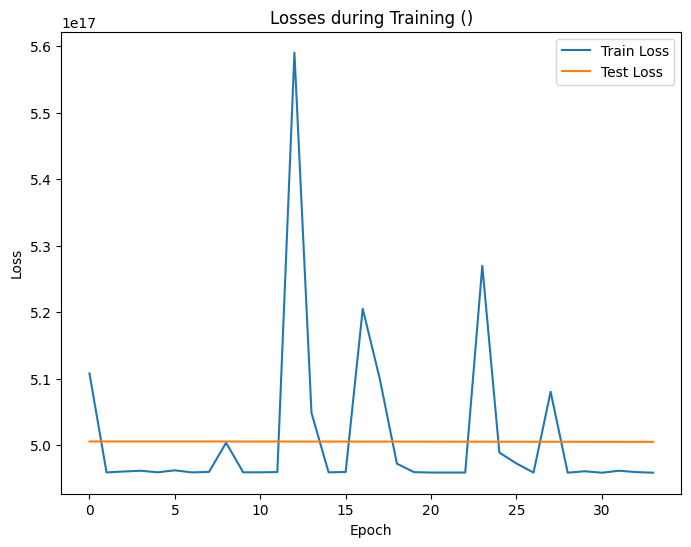

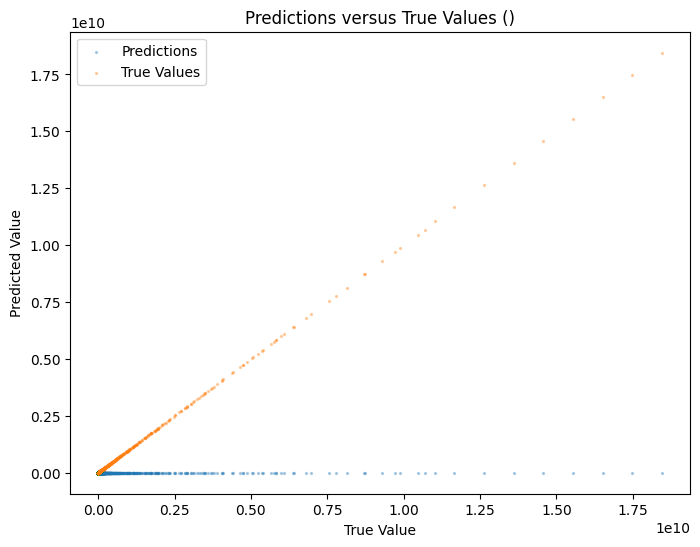

In [39]:

best_model = create_network(input_size, output_size, [best_hidden_sizes], [best_activation_class], output_activation_class=best_output_activation_class)
best_network = VariableNetwork(best_model)
best_optimizer = optim.Adam(best_network.parameters(), lr=best_config["lr"])
best_loss_fn = nn.MSELoss()

best_train_losses, best_test_losses = train_network(best_network, best_optimizer, best_loss_fn,
                                                        best_config["batch_size"], best_config["epochs"],
                                                        X_train.dataset, outputs_train[i].dataset,
                                                        X_test.dataset, outputs_test[i].dataset)

# Print the test loss for the best model
print(f"Test loss for the best model: {best_test_losses[-1]}")


plot_losses(best_train_losses, best_test_losses, function_names[i])
plot_predictions(best_network, X, outputs[i], function_names[i])

# Save the network with hyperparameters in the file name
torch.save(best_network, f"best_network_{function_names[i]}.pt")

## Two hidden layers

<u>The code became messy</u> and I want to reconsider it.

- We continue and now want to optimize for two hidden layers. We refactor the code to make use of an objective function, although this was not needed.

- We can now also choose between the Adam and the SGD optimizer.

- For clarity I will redefine previous functions and focus only on `h`.

What I mean is that the **following section is self contained** and that I can just start running the notebook from here.

In [1]:
# Import the necessary modules
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import optuna


In [3]:

# Define a new class that inherits from nn.Module
class VariableNetwork(nn.Module):
    # Define the constructor that takes the model as an argument
    def __init__(self, model):
        # Call the parent constructor
        super().__init__()
        # Assign the model to an attribute
        self.model = model

    # Override the forward function
    def forward(self, x):
        # Loop over the layers in the ModuleList
        for layer in self.model:
            # Apply the layer to the input
            x = layer(x)
        # Return the final output
        return x

def h(x1, x2, x3):
    return x3 * x1**(x2)


In [4]:

# Define the range and step size for the input variables
x1_range = (0, 10)
x2_range = (0, 10)
x3_range = (0, 10)
dx = 0.5

# Generate the input data by sampling uniformly from the ranges
x1 = np.arange(*x1_range, dx)
x2 = np.arange(*x2_range, dx)
x3 = np.arange(*x3_range, dx)
X1, X2, X3 = np.meshgrid(x1, x2, x3)
X = np.stack([X1.flatten(), X2.flatten(), X3.flatten()], axis=1)

# Compute the output data by applying the functions
Y_h = h(X[:, 0], X[:, 1], X[:, 2])

# Convert the input and output data to torch tensors
X = torch.from_numpy(X).float()
Y_h = torch.from_numpy(Y_h).float().unsqueeze(1)

# Split the data into train and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
test_size = len(X) - train_size
X_train, X_test = torch.utils.data.random_split(X, [train_size, test_size])
Y_h_train, Y_h_test = torch.utils.data.random_split(Y_h, [train_size, test_size])


In [5]:

# Define a function to create a neural network with given hyperparameters
def create_network(input_size, output_size, hidden_sizes, activations, output_activation=None):
    # Create a ModuleList to hold the layers
    model = nn.ModuleList()
    # Loop over the hidden sizes and activations
    for hidden_size, activation in zip(hidden_sizes, activations):
        # Add a linear layer with the input size and hidden size
        model.append(nn.Linear(input_size, hidden_size))
        # Use a batch normalization layer between linear and activation layers to improve training stability
        #model.append(nn.BatchNorm1d(hidden_size))
        # Add an activation layer with the given activation function
        model.append(activation())
        # Update the input size for the next layer
        input_size = hidden_size
    # Add the final output layer with the output size
    model.append(nn.Linear(input_size, output_size))
    # If an output activation function is specified, add it to the model
    if output_activation:
        model.append(output_activation())
    # Return the model
    return model


In [6]:

# Define a function to train a neural network with given hyperparameters and data
def train_network(model, optimizer, loss_fn, batch_size, epochs, x_train, Y_train, X_test=None, Y_test=None):
    # Create a data loader for the training data
    train_loader = DataLoader(
        dataset=torch.utils.data.TensorDataset(X_train, Y_train),
        batch_size=batch_size,
        shuffle=True
    )
    # Initialize a list to store the training losses
    train_losses = []
    # Initialize a list to store the test losses if test data is given
    if X_test is not None and Y_test is not None:
        test_losses = []
    # Loop over the number of epochs
    for epoch in range(epochs):
        # Initialize a variable to store the running loss for this epoch
        running_loss = 0.0
        # Loop over the batches of training data
        for inputs, targets in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass: compute the outputs from the inputs
            outputs = model(inputs)
            # Compute the loss from the outputs and targets
            loss = loss_fn(outputs, targets)
            # Backward pass: compute the gradients from the loss
            loss.backward()
            # Update the parameters using the optimizer
            optimizer.step()
            # Accumulate the running loss
            running_loss += loss.item()
        # Compute and append the average training loss for this epoch
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        # Print the progress
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
        # If test data is given, compute and append the test loss for this epoch
        if X_test is not None and Y_test is not None:
            # Compute the outputs from the test inputs
            outputs = model(X_test)
            # Compute the loss from the outputs and test targets
            loss = loss_fn(outputs, Y_test)
            # Append the test loss
            test_loss = loss.item()
            test_losses.append(test_loss)
            # Print the progress
            print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")
    # Return the train and test losses if test data is given, otherwise return only train losses
    if X_test is not None and Y_test is not None:
        return train_losses, test_losses
    else:
        return train_losses


In [7]:

# Define a function to plot the losses during training
def plot_losses(train_losses, test_losses=None, function_name=None, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot the train losses
    ax.plot(train_losses, label="Train Loss")
    # If test losses are given, plot them as well
    if test_losses is not None:
        ax.plot(test_losses, label="Test Loss")
    # Set the title, labels, and legend
    ax.set_title(f"Losses during Training ({hyperparameters})")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"losses_{function_name}_{hyperparameters}.png")
    plt.show()

# Define a function to plot the predictions versus the true values
def plot_predictions(model, X, Y_true, function_name, hyperparameters=""):
    # Create a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))
    # Compute the predictions from the inputs
    Y_pred = model(X).detach().numpy()
    # Plot the predictions and the true values as scatter plots
    ax.scatter(Y_true, Y_pred, label="Predictions", s=2, alpha=0.3)
    ax.scatter(Y_true, Y_true, label="True Values", s=2, alpha=0.3)
    # Set the title, labels, and legend
    ax.set_title(f"Predictions versus True Values ({hyperparameters})")
    ax.set_xlabel("True Value")
    ax.set_ylabel("Predicted Value")
    ax.legend()
    # Save and show the plot
    # Use format method to insert hyperparameters into file name
    plt.savefig(f"predictions_{function_name}_{hyperparameters}.png")
    plt.show()


In [25]:
def tune_network(trial, input_size, output_size, create_network, train_loader, val_loader, num_epochs):
    hidden_sizes = [trial.suggest_int("hidden_size1", 16, 128), trial.suggest_int("hidden_size2", 16, 128)]
    activation_classes = [getattr(nn, trial.suggest_categorical("activation_class1", ["ReLU", "LeakyReLU", "Tanh"])),
                          getattr(nn, trial.suggest_categorical("activation_class2", ["ReLU", "LeakyReLU", "Tanh"]))]
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    optimizer_class = trial.suggest_categorical("optimizer_class", ["Adam", "SGD"])

    model = create_network(input_size, output_size, hidden_sizes, activation_classes)
    model = VariableNetwork(model)

    if optimizer_class == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_class == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            x, y = batch
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x_val, y_val = batch
                y_val_pred = model(x_val)
                val_loss += loss_fn(y_val_pred, y_val).item()

        val_loss /= len(val_loader)

    return val_loss


In [26]:
def objective(trial, input_size, output_size, create_network, X_train, Y_h_train, X_test, Y_h_test, num_epochs):
    # TODO: Update docstring.
    """Optimize the hyperparameters of a neural network using Optuna.

    Args:
        trial (optuna.trial.Trial): The trial object that samples hyperparameters.
        input_size (int): The size of the input layer of the network.
        output_size (int): The size of the output layer of the network.
        create_network (function): A function that takes input_size, output_size, hidden_sizes,
            activation_classes and output_activation_class as arguments and returns a nn.Module object.
        train_loader (torch.utils.data.DataLoader): The data loader for the training set.
        val_loader (torch.utils.data.DataLoader): The data loader for the validation set.
        num_epochs (int): The number of epochs to train the network.

    Returns:
        float: The validation loss of the network after training.

    """
    # Convert the subsets back to tensors
    X_train_tensor = X[X_train.indices]
    Y_h_train_tensor = Y_h[Y_h_train.indices]
    X_test_tensor = X[X_test.indices]
    Y_h_test_tensor = Y_h[Y_h_test.indices]

    # Create DataLoaders for training and validation data
    batch_size = 64
    train_loader = DataLoader(torch.utils.data.TensorDataset(X_train_tensor, Y_h_train_tensor),
                            batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(torch.utils.data.TensorDataset(X_test_tensor, Y_h_test_tensor),
                            batch_size=batch_size, shuffle=True)

    # Sample hyperparameters
    hidden_sizes = [
        trial.suggest_int("hidden_sizes[0]", 32, 256),
        trial.suggest_int("hidden_sizes[1]", 32, 256),
    ]
    activation_classes = [
        trial.suggest_categorical("activation_classes[0]", ["ReLU", "Tanh", "Sigmoid"]),
        trial.suggest_categorical("activation_classes[1]", ["ReLU", "Tanh", "Sigmoid"]),
    ]
    output_activation_class = trial.suggest_categorical("output_activation_class", [None, "Softmax", "Sigmoid"])
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)

    # Convert activation class names to actual classes
    activation_classes = [getattr(nn, act_class_name) for act_class_name in activation_classes]
    if output_activation_class:
        output_activation_class = getattr(nn, output_activation_class)

    # Train the network
    model = create_network(input_size, output_size, hidden_sizes, activation_classes, output_activation_class)
    optimizer_class = getattr(torch.optim, optimizer_name)
    val_loss = tune_network(model, optimizer_class, learning_rate, train_loader, val_loader, num_epochs)

    return val_loss


In [23]:
import optuna
study = optuna.create_study(direction="minimize")

[I 2023-05-02 16:54:21,713] A new study created in memory with name: no-name-aa6aecd9-4208-4e3a-bfdd-8b7569cc2427


In [30]:
input_size = 3  # The number of input variables (x1, x2, x3)
output_size = 1  # The number of output variables (y)
num_epochs = 50
n_trials = 100
timeout = 3600
study.optimize(lambda trial: tune_network(trial, input_size, output_size, create_network, X_train, Y_h_train, X_test, Y_h_test, num_epochs), n_trials=n_trials, timeout=timeout)

[W 2023-05-02 16:57:40,076] Trial 4 failed with parameters: {} because of the following error: TypeError('tune_network() takes 7 positional arguments but 9 were given').
Traceback (most recent call last):
  File "/home/codespace/.python/current/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_906/3438182241.py", line 6, in <lambda>
    study.optimize(lambda trial: tune_network(trial, input_size, output_size, create_network, X_train, Y_h_train, X_test, Y_h_test, num_epochs), n_trials=n_trials, timeout=timeout)
TypeError: tune_network() takes 7 positional arguments but 9 were given
[W 2023-05-02 16:57:40,077] Trial 4 failed with value None.


TypeError: tune_network() takes 7 positional arguments but 9 were given

In [ ]:

# Create and train the best model using the optimization function
best_model = find_best_model(optimization_function=h, search_space=search_space, n_trials=n_trials)
best_network = VariableNetwork(create_network(*best_model["model_args"]))
best_optimizer = best_model["optimizer"](best_network.parameters(), **best_model["optimizer_args"])
best_loss_fn = best_model["loss_fn"]

# Train the best model and obtain train and test losses
best_train_losses, best_test_losses = train_network(
    best_network, best_optimizer, best_loss_fn,
    batch_size, num_epochs, X_train, Y_h_train, X_test, Y_h_test)

# Print the test loss for the best model
print(f"Best Model Test Loss: {best_test_losses[-1]:.4f}")

plot_losses(best_train_losses, best_test_losses, function_name="h")
plot_predictions(best_network, X, Y_h, function_name="h")

# Save the network with hyperparameters in the file name
torch.save(best_network, f"best_network_h.pt")

